# Braitenberg Vehicles

This *Jupyter Notebook* is dedicated to the study of **Braitenberg Vehicles**. 

The following study will be developed by the implementation of *Python* code for the application and visualization of the concepts learned with the use of *NumPy* and *Plotly* libraries. 

The following models are based and adapted from [Vehicles: Experiments in Synthetic Psychology](https://www.amazon.com/Vehicles-Experiments-Psychology-Valentino-Braitenberg/dp/0262521121), by Valentino Braitenberg.

---

## Autonomous Mobile Systems based on Simple Rules

In his book, Braitenberg proposes a series of ideas that describes the functioning of hypothetical vehicles that have life-like behaviour, strongly inspired by biological examples. These ideas, even though not mathematically formalized in the book, are rooted on feedback-based systems with sensors and actuators, just like classical control theory. Thus, this theory created an easy and experimental approach on developing environment-responsive mobile robots. 

In the original material, the standard vehicle is defined as a mobile system with two sensors on the front and two independent wheel actuators on the back. The sensors could be of any type, capable of measuring some kind of physical stimuli on the environment - light, temperature, distance or even magnetic fields. 

**The main idea behind the behaviour of this autonomous mobile system is how and which sensors affect the wheels.**

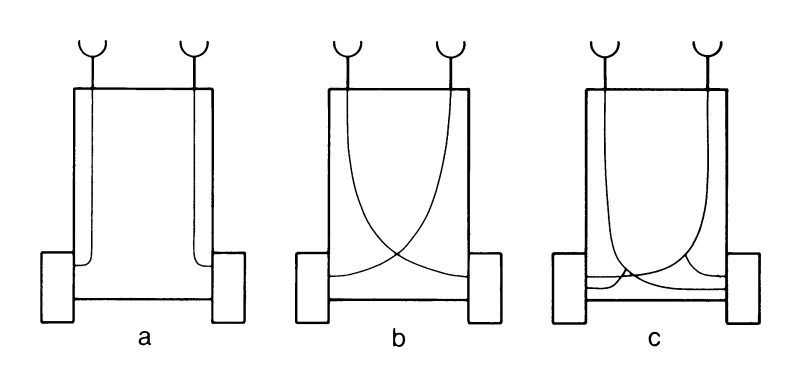

The image above illustrates how the sensors affect the wheels based on connections. That's the *which sensor affect which actuator* part. The *how* part consists of defining the relationship between the intensity of the stimulus on the sensor and the velocity of the wheel. In this case, we can formally define:

$$\dot{\phi} = B(S)$$

Where $\dot{\phi}$ is the angular velocity of the wheel, $S$ is the stimulus on the sensor linked to the wheel, and $B$ is a behaviour function.

When these are defined, emotion-like behaviours emerge.

---

### Fear and Aggression

Fear and Aggression (vehicles 2a and 2b respectively) are the first vehicles presented in the text. They represent behaviours that emerge when an increasing stimulus produces an increasing wheel velocity.

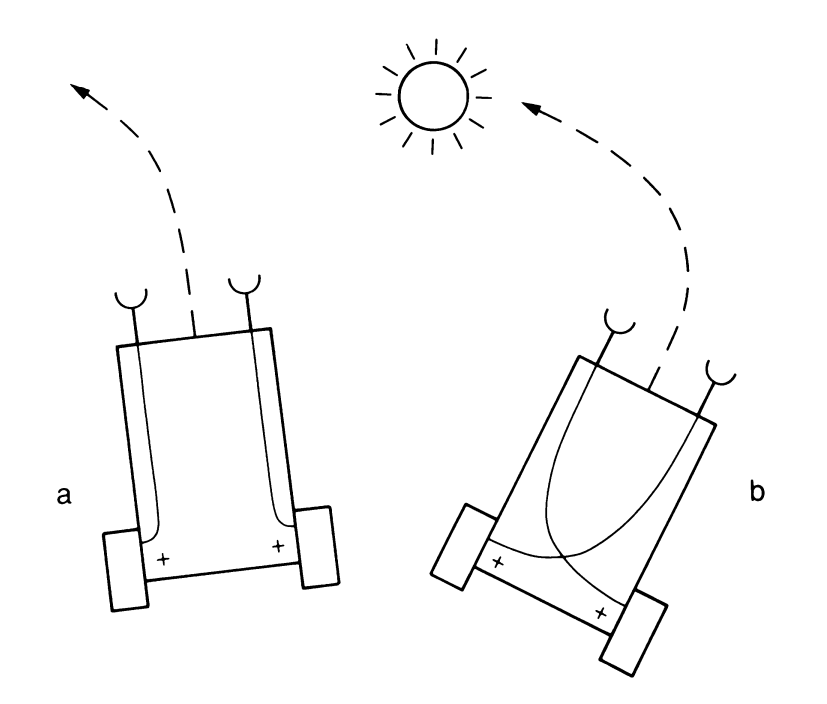

As illustrated above, vehicle 2a's left sensor has an influence on its left wheel, and the right sensor has an influence on its right wheel, making the vehicle naturally turn away from the source of stimulus. Since the higher the source of stimuli is, the faster the wheels turn, then the vehicle will react faster when closer to the source, creating a fear-like behaviour. Formally:

$$
\begin{cases}
\dot{\phi}_L = B_+(S_L) \\
\dot{\phi}_R = B_+(S_R)
\end{cases}
$$

In vehicle 2b, the sensor-actuator influence is crossed. Intead of turning away from the source, it drives right into it, and faster as it gets closer, generating an agression-like response. Thus:

$$
\begin{cases}
\dot{\phi}_L = B_+(S_R) \\
\dot{\phi}_R = B_+(S_L)
\end{cases}
$$

---

### Love and Curiosity

Love and Curiosity (vehicles 3a and 3b respectively) are introduced next. They represent behaviours that emerge when an increasing stimulus produces a decreasing wheel velocity.

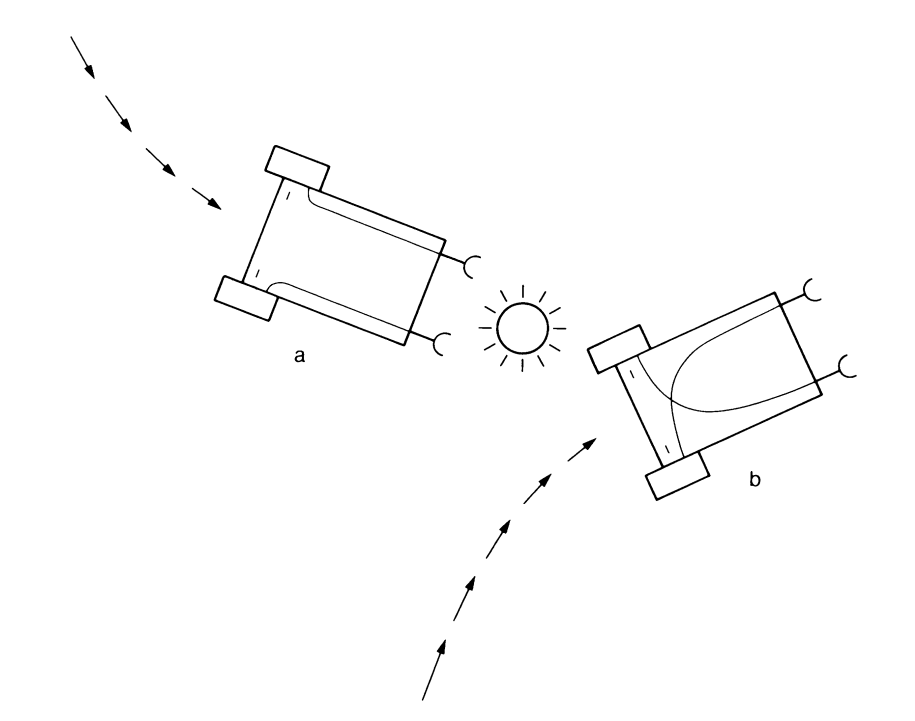

As illustrated above, vehicle 3a's is wired like vehicle 2a, but with a decreasing sensor-actuator relationship. The emergent behaviour is a vehicle that rushes when away from the stimuli source, deaccelerating when getting closer, emulating a love-like behaviour. Formally:

$$
\begin{cases}
\dot{\phi}_L = B_-(S_L) \\
\dot{\phi}_R = B_-(S_R)
\end{cases}
$$

In vehicle 3b, the sensor-actuator influence is crossed, like vehicle 2b. Intead of going to the source, it drives away from it, but slower as it's getting closer (like just wanting to take a quick peek then going away, searching for another source), generating an explorer-like response. Thus:

$$
\begin{cases}
\dot{\phi}_L = B_-(S_R) \\
\dot{\phi}_R = B_-(S_L)
\end{cases}
$$

---

In [16]:
# Importing modules...
import numpy as np

import sys

sys.path.append("..")  # Go back to base directory

from modules.graph import *
from modules.viewer3d import *
from modules.differential_drive import *

In [17]:
# Differential drive model
class BraitenbergVehicle(DifferentialDrive):
    def __init__(
        self,
        r,  # Wheel radius
        s,  # Space between wheels
        d,  # Sensor to sensor distance
        l,  # Sensor to wheels distance
        h=0.0,  # Robot height
        behaviour=None,  # Behaviour vector
        dt=1e-4,  # Differential time step
        # Initial pose parameters (aligned with the inertial frame and unmoving)
        x=0.0,
        y=0.0,
        theta=0.0,
    ):
        DifferentialDrive.__init__(self, r, s, h, dt, x, y, theta)

        self.d = d
        self.l = l

        self.behaviour = behaviour

    def fear(self, stimuli_L, stimuli_R):
        phi_dot_L = self.behaviour["fear"] * stimuli_L
        phi_dot_R = self.behaviour["fear"] * stimuli_R

        return np.array([phi_dot_L, phi_dot_R])

    def agression(self, stimuli_L, stimuli_R):
        phi_dot_L = self.behaviour["agression"] * stimuli_R
        phi_dot_R = self.behaviour["agression"] * stimuli_L

        return np.array([phi_dot_L, phi_dot_R])

    def love(self, stimuli_L, stimuli_R):
        phi_dot_L = self.behaviour["love"] / stimuli_L
        phi_dot_R = self.behaviour["love"] / stimuli_R

        return np.array([phi_dot_L, phi_dot_R])

    def curiosity(self, stimuli_L, stimuli_R):
        phi_dot_L = self.behaviour["curiosity"] / stimuli_R
        phi_dot_R = self.behaviour["curiosity"] / stimuli_L

        return np.array([phi_dot_L, phi_dot_R])

    def stimulate(self, stimuli_L, stimuli_R):
        phi_dot_L, phi_dot_R = (
            self.fear(stimuli_L, stimuli_R)
            + self.agression(stimuli_L, stimuli_R)
            + self.love(stimuli_L, stimuli_R)
            + self.curiosity(stimuli_L, stimuli_R)
        )

        self.kinematic_model(phi_dot_L, phi_dot_R)

    def get_sensors_position(self):
        P = self.get_pose()

        sensor_L_position = (P[:3, 3] + self.l * P[:3, 0] + self.d * P[:3, 1]).reshape(
            -1, 3
        )
        sensor_R_position = (P[:3, 3] + self.l * P[:3, 0] - self.d * P[:3, 1]).reshape(
            -1, 3
        )

        return sensor_L_position, sensor_R_position

In [18]:
behaviour = {"fear": 1e4, "agression": 0.0, "love": 0.0, "curiosity": 0.0}

# Instanciating and simulating the model
BV = BraitenbergVehicle(
    # Robot geometry
    r=15.0,  # In cm
    s=60.0,  # In cm
    h=30.0,  # In cm
    d=60.0,  # In cm
    l=10.0,  # In cm
    behaviour=behaviour,
    # Time parameters
    dt=1e-3,
    # Initial pose parameters
    x=0.0,  # In cm
    y=0.0,  # In cm
    theta=0.0,  # In radians
)

# Simulation time parameters
start_time = 0.0  # In Seconds
stop_time = 50.0  # In Seconds

time_vector = np.linspace(start_time, stop_time, int((stop_time - start_time) / BV.dt))

stimulus_intensity = 100.0
stimulus_position = np.array([[400.0], [400.0], [30.0]])

# Compute solution
output, poses, positions = [], [], []
for t in time_vector:
    sensor_L, sensor_R = BV.get_sensors_position()

    stimuli_L = stimulus_intensity / (np.linalg.norm(stimulus_position - sensor_L) ** 2)
    stimuli_R = stimulus_intensity / (np.linalg.norm(stimulus_position - sensor_R) ** 2)

    BV.stimulate(stimuli_L, stimuli_R)

    output.append(BV.get_output())
    positions.append(BV.get_position())
    poses.append(BV.get_pose())

output = np.hstack(output)
trajectory = np.hstack(positions)

In [19]:
# Plot output variables
graph = Graph(
    title="Outputs in Time Domain",
    axis_title=("Time (s)", "Differential Drive Robot Pose Parameters"),
)

graph.add_trace(points=np.vstack((time_vector, output[0])), name="x (cm)")

graph.add_trace(points=np.vstack((time_vector, output[1])), name="y (cm)")

graph.add_trace(
    points=np.vstack((time_vector, np.degrees(output[2]))), name="theta (deg)"
)

graph.figure.show(renderer="notebook_connected")

In [20]:
# Create the Scene Viewer
scene = Viewer3D(
    title="Differential Drive Robot Trajectory Display", size=1000
)  # In cm

# Add inertial reference
scene.add_frame(transformation=np.eye(4), name="Inertial Reference", axis_size=40)

# Add robot trajectory
scene.add_points(
    points=trajectory,
    name="DDR",
    color=time_vector,
    colorscale="plasma",
    range=[time_vector[0], time_vector[-1] + 0.5],
    colorbar="Time (s)",
)

# Display poses
n_poses = 10
for pose in poses[:: len(poses) // n_poses]:
    # Add poses
    scene.add_frame(transformation=pose, axis_size=20, color="black")

# Add robot trajectory
scene.add_points(points=stimulus_position, name="Stimuli Source")

scene.figure.show(renderer="notebook_connected")